# Unsupervised Learning: Identifying Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import pprint

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, let's load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we'll need an additional argument in our [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, we'll take a little bit of time just browsing the general structure of the dataset and feature summary file. We'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help us get our bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS General Population Dataset rows: ", azdias.shape[0], "columns: ", azdias.shape[1])
print("AZDIAS Feature Summary Dataset rows: ", feat_info.shape[0], "columns: ", feat_info.shape[1])

AZDIAS General Population Dataset rows:  891221 columns:  85
AZDIAS Feature Summary Dataset rows:  85 columns:  4


In [4]:
print("*******First 20 rows of AZDIAS General Population Dataset*********")
# truth = azdias["CJT_GESAMTTYP"] == 0
# print(azdias["CJT_GESAMTTYP"].dtype)
# truth_data = azdias[truth]
# print(truth.sum())
azdias.head(20)

*******First 20 rows of AZDIAS General Population Dataset*********


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
print("*******First 20 rows of AZDIAS Feature Summary Dataset*********")
print(feat_info.head(20))

*******First 20 rows of AZDIAS Feature Summary Dataset*********
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAH

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. We'll onvert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
#Output data types of azdias features
azdias_dtypes =  azdias.dtypes

#Check int64 azdias dataset columns
check_int_dtypes_azdias = (azdias_dtypes == "int64")
int_columns_azdias = azdias_dtypes[check_int_dtypes_azdias].index.values


#Check str azdias dataset columns
check_str_dtypes_azdias = (azdias_dtypes == "object")
str_columns_azdias = azdias_dtypes[check_str_dtypes_azdias].index.values

#Check float64 azdias dataset columns
check_float_dtypes_azdias = (azdias_dtypes == "float64")
float_columns_azdias = azdias_dtypes[check_float_dtypes_azdias].index.values

#Print number of columns of different data types
print("Number of int64 columns in azdias dataset: ", len(int_columns_azdias))
print("Number of float64 columns in azdias dataset: ", len(float_columns_azdias))
print("Number of str columns in azdias dataset: ", len(str_columns_azdias))

Number of int64 columns in azdias dataset:  32
Number of float64 columns in azdias dataset:  49
Number of str columns in azdias dataset:  4


In [7]:
print("*****What are the missing, unknown codes for string based columns in azdias dataset?******")
print("\n")
for each_item in str_columns_azdias:
    print(feat_info[feat_info["attribute"] == each_item])

*****What are the missing, unknown codes for string based columns in azdias dataset?******


      attribute information_level         type missing_or_unknown
55  OST_WEST_KZ          building  categorical               [-1]
          attribute information_level         type missing_or_unknown
57  CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
         attribute information_level         type missing_or_unknown
58  CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
          attribute information_level   type missing_or_unknown
59  CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]


In [8]:
#Create a dictionary whose keys are features and values are it's missing/unknown items
dict_attr_to_missing_map = {}

for row_num in range(feat_info.shape[0]):   # for every row in feat_info dataset
    if feat_info["missing_or_unknown"][row_num] != str([]):   # ignore no missing item features
        to_list = feat_info["missing_or_unknown"][row_num].split(",")  # split string to list
        to_list[0] = to_list[0][1:]
        to_list[-1] = to_list[-1][0:-1]
        if (feat_info["attribute"][row_num] not in str_columns_azdias):  #check if column data type is int or float
            dict_attr_to_missing_map[feat_info["attribute"][row_num]] = list(map(int, to_list))
        else:    
            dict_attr_to_missing_map[feat_info["attribute"][row_num]] = to_list
            
print(len(dict_attr_to_missing_map))

75


In [9]:
# Identify missing or unknown data values in azdias and convert them to NaNs.
azdias_copy =  azdias.copy()

for each_key in dict_attr_to_missing_map.keys():
    azdias_copy[each_key].replace(to_replace = dict_attr_to_missing_map[each_key], value = np.nan, inplace=True)
    
azdias_copy.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We'll use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project let's just remove them from the dataframe. Check out the discussion below on how columns were dropped from the dataframe.

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_perc_col_stats = azdias_copy.isnull().sum()
null_perc_col_stats = null_perc_col_stats*100/azdias.shape[0]  #convert to percentage to avoid huge value differences
null_perc_col_stats.head()

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
dtype: float64

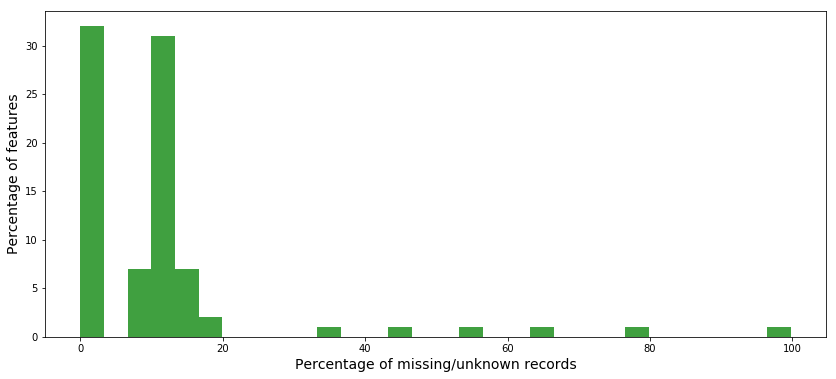

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(14, 6))
plt.hist(null_perc_col_stats.values, 30, facecolor='g', alpha=0.75)
plt.xlabel('Percentage of missing/unknown records', fontsize=14)
plt.ylabel('Percentage of features', fontsize=14)
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_being_dropped = null_perc_col_stats[null_perc_col_stats > 20].index.values
print("***Columns being dropped")
print(columns_being_dropped)
print("***Remaining dataset shape")
azdias_no_outlier = azdias_copy.drop(columns_being_dropped, axis = 1)
print(azdias_no_outlier.shape)

***Columns being dropped
['AGER_TYP' 'GEBURTSJAHR' 'TITEL_KZ' 'ALTER_HH' 'KK_KUNDENTYP'
 'KBA05_BAUMAX']
***Remaining dataset shape
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram, it is evident that except for a few columns, rest all have missing records < 20%.
Digging deeper, we find that there are six outlier columns with high missing records which are printed above. Briefly going through their desrciption, it seemed like other columns could in some way capture the idea behind these columns (eg: GEBURTSJAHR which is the year of birth can be roughly captured using PRAEGENDE_JUGENDJAHRE column).
Considering we're removing < 10% of the columns, it should be fine. Having columns with few valid data points could potentially lead to skewed results. So they've been removed from further analysis.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Let's divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We'll select at least five of these columns and compare the distribution of values.

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, let's continue our analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
null_perc_row_stats = azdias_no_outlier.isnull().sum(axis=1)
null_perc_row_stats = null_perc_row_stats*100/azdias_no_outlier.shape[1]  #convert to percentage to avoid huge value differences
null_perc_row_stats.head()

0    54.430380
1     0.000000
2     0.000000
3     8.860759
4     0.000000
dtype: float64

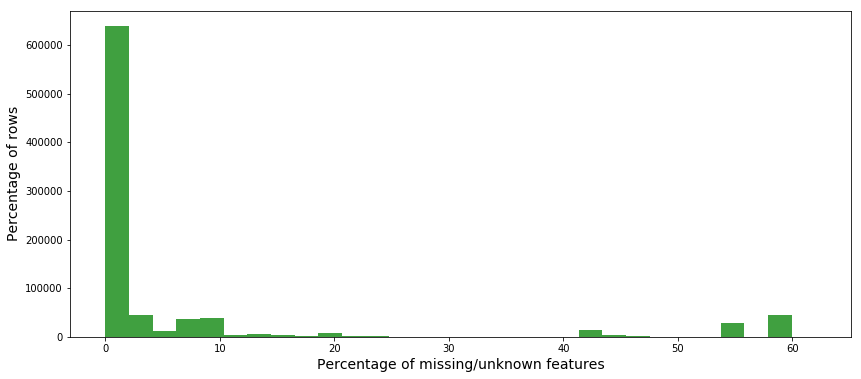

In [15]:
# Investigate patterns in the amount of missing data in each row.
plt.figure(figsize=(14, 6))
plt.hist(null_perc_row_stats.values, 30, facecolor='g', alpha=0.75)
plt.xlabel('Percentage of missing/unknown features', fontsize=14)
plt.ylabel('Percentage of rows', fontsize=14)
plt.show()

From the above histogram, we see a clear distinction between low missing and high missing rows at 30%. Case could be made there's another demarkation at 10%. The decision comes down to how aggressive does one want to be about dropping data. We'll take our chances, go aggressive and split data using 10% demarkation.

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_high_missing = null_perc_row_stats[null_perc_row_stats > 10].index.values
rows_low_missing = null_perc_row_stats[null_perc_row_stats < 10].index.values
print(rows_high_missing.shape, rows_low_missing.shape)
#print(rows_high_missing[:2], rows_low_missing[:2])

(144112,) (747109,)


In [17]:
#Previous cell continued
azdias_no_outlier_low_miss = azdias_no_outlier.drop(rows_high_missing)
azdias_no_outlier_high_miss = azdias_no_outlier.drop(rows_low_missing)
print(azdias_no_outlier_low_miss.shape, azdias_no_outlier_high_miss.shape)

(747109, 79) (144112, 79)


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


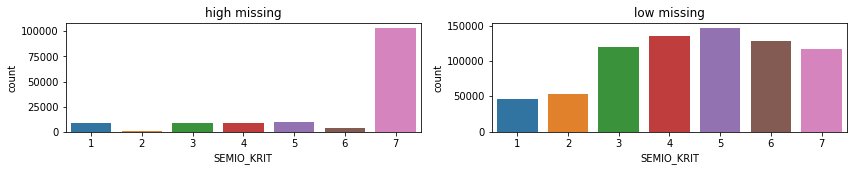

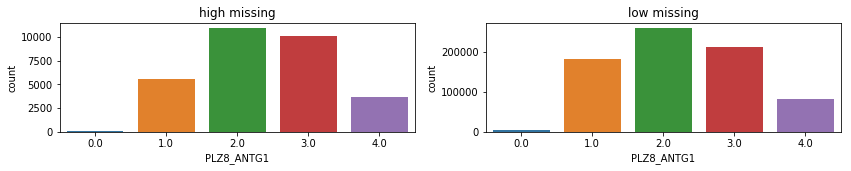

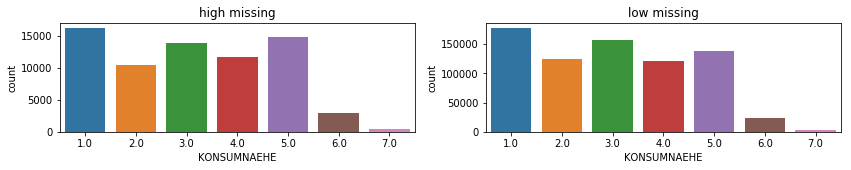

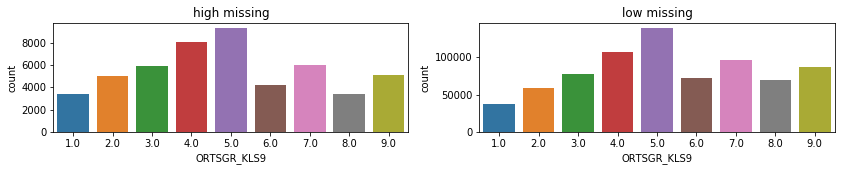

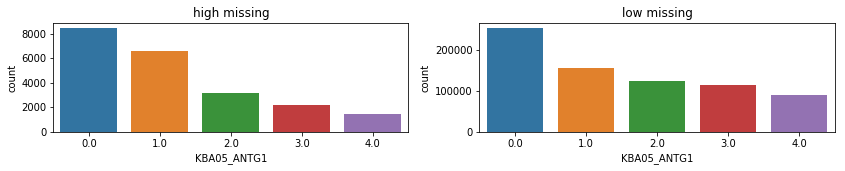

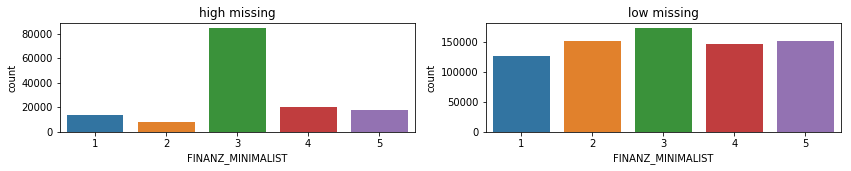

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#plot function
def barplot_by_side(data1, data2, feature):    
    f, axes = plt.subplots(1, 2, figsize=(14, 2))
    sns.countplot(data1[feature], ax=axes[0])
    axes[0].set_title("high missing")
    sns.countplot(data2[feature], ax=axes[1])
    axes[1].set_title("low missing")
    f.show()

# randomly select features
np.random.seed(38)
features_array = feat_info["attribute"].values
random_choice_features = np.random.choice(features_array, size=6)

#get bar chart comparison for selected features
for each_feat in random_choice_features:
    barplot_by_side(azdias_no_outlier_high_miss, azdias_no_outlier_low_miss, each_feat)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on random selection & plotting of six features side-by-side for high missing rows & low missing rows data, we see that the distributions match reasonably well for 4 out of 6 features. So the idea of going aggressive with dropping "missing row data above 10%" wasn't a bad idea.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. The third column of the feature summary (`feat_info`) gives a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, let's make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: 'categorical', and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [19]:
# How many features are there of each data type?
feat_info_mod = feat_info.set_index('attribute')
feat_info_mod.drop(labels = columns_being_dropped, inplace=True) #drop the removed features and run sum on that
data_types = feat_info_mod["type"].unique()

num_data_types = {}
for each_type in data_types:
    count = (feat_info_mod["type"] == each_type).sum()
    num_data_types[each_type] = count
    
num_data_types

{'ordinal': 49, 'categorical': 18, 'mixed': 6, 'numeric': 6}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, let's perform one of the following:
- For binary (two-level) categoricals that take numeric values, let's keep them without needing to do anything.
- For binary variables that takes on non-numeric values, let's either re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can either encode the values using multiple dummy variables or just drop them from the analysis.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info_mod[feat_info_mod["type"] == "categorical"].index.values
#azdias_subset_categorical = azdias_no_outlier_low_miss.loc[:,categorical_features]
#azdias_subset_categorical.head()

In [21]:
for each_cat in categorical_features:
    num_of_uniq = azdias_no_outlier_low_miss.loc[:,each_cat].nunique()
    data_type = azdias_no_outlier_low_miss.loc[:,each_cat].dtype
    if num_of_uniq == 2 and data_type == "object":
        print(each_cat, ":       binary non-numeric,        Number of categories: ", num_of_uniq)
    elif num_of_uniq == 2:
        print(each_cat, ":       binary numeric,            Number of categories: ", num_of_uniq)
    else:
        print(each_cat, ":       multi level,               Number of categories: ", num_of_uniq)
    

ANREDE_KZ :       binary numeric,            Number of categories:  2
CJT_GESAMTTYP :       multi level,               Number of categories:  6
FINANZTYP :       multi level,               Number of categories:  6
GFK_URLAUBERTYP :       multi level,               Number of categories:  12
GREEN_AVANTGARDE :       binary numeric,            Number of categories:  2
LP_FAMILIE_FEIN :       multi level,               Number of categories:  11
LP_FAMILIE_GROB :       multi level,               Number of categories:  5
LP_STATUS_FEIN :       multi level,               Number of categories:  10
LP_STATUS_GROB :       multi level,               Number of categories:  5
NATIONALITAET_KZ :       multi level,               Number of categories:  3
SHOPPER_TYP :       multi level,               Number of categories:  4
SOHO_KZ :       binary numeric,            Number of categories:  2
VERS_TYP :       binary numeric,            Number of categories:  2
ZABEOTYP :       multi level,             

In [22]:
#Replacing binary non_numeric values in OST_WEST_KZ columns with numbers
ost_west_kz_elements = azdias_no_outlier_low_miss["OST_WEST_KZ"].unique()
azdias_no_outlier_low_miss_encoded = azdias_no_outlier_low_miss.copy()
azdias_no_outlier_low_miss_encoded["OST_WEST_KZ"].replace({ost_west_kz_elements[0]:0, ost_west_kz_elements[1]:1}, value = None, inplace=True)

#Dropping columns LP_FAMILIE_FEIN, LP_STATUS_FEIN, CAMEO_DEU_2015 as they are redundant
azdias_no_outlier_low_miss_encoded.drop(["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "CAMEO_DEU_2015"], axis=1, inplace=True)

#Re-encoding multi level categorical features
drop_cat_columns = [0, 4, 5, 7, 11, 12, 15, 17] #column numbers generated using categorical_features array
azdias_no_outlier_low_miss_encoded = pd.get_dummies(azdias_no_outlier_low_miss_encoded, columns = np.delete(categorical_features, drop_cat_columns))

In [23]:
#Printing some sample encoded features
azdias_no_outlier_low_miss_encoded.iloc[:5,100:130]

,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

Out of the 18 categorical features, 4 are binary numeric,  1 is binary non-numeric and the rest 13 are multi level features.
  1. As mentioned previously, binary numeric columns were left untouched. 
  
  
  2. The one binary non-numeric column was converted into numbers by replacing it's current values.
  
  
  3. For multi-level features, three columns **LP_FAMILIE_FEIN, LP_STATUS_FEIN, CAMEO_DEU_2015** were dropped from further    analysis as they are long, detailed forms of these columns **LP_FAMILIE_GROB, LP_STATUS_GROB, CAMEO_DEUG_2015**. The rest were re-encoded and the resultant dataset will be used further.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. We'll refer `Data_Dictionary.md` to get details on these features. Check out discussion section below for more info on how this task was handled.

In [24]:
#Investigating mixed features
mixed_features = feat_info_mod[feat_info_mod["type"] == "mixed"].index.values
mixed_features

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

In [25]:
azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE'].unique(), azdias_no_outlier_low_miss_encoded['CAMEO_INTL_2015'].unique()

(array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
          2.,   1.,  12.,  13.,   7.]),
 array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '41', '34',
        '55', '33', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object))

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#Dictionaries to map current variable to two new variables
movement_dict = {(1, 3, 5, 8, 10, 12, 14): 0, (2, 4, 6, 7, 9, 11, 13, 15): 1}
decade_dict = {(1, 2): 0, (3, 4): 1, (5, 6, 7): 2, (8, 9): 3, (10, 11, 12, 13): 4, (14, 15): 5}

#Create the two new columns
azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE']
azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE']

#modify the new columns
for keys, values in decade_dict.items():
     azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(to_replace = keys, value = values, inplace=True)

for keys, values in movement_dict.items():
     azdias_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(to_replace = keys, value = values, inplace=True)

#printing some columns to check the mapping
azdias_no_outlier_low_miss_encoded.loc[:,['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']].tail(10)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
891211,8.0,3.0,0.0
891212,3.0,1.0,0.0
891213,11.0,4.0,1.0
891214,14.0,5.0,0.0
891215,10.0,4.0,0.0
891216,14.0,5.0,0.0
891217,10.0,4.0,0.0
891218,14.0,5.0,0.0
891219,14.0,5.0,0.0
891220,3.0,1.0,0.0


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Convert strings to numeric values in "CAMEO_INTL_2015" column
num_converted = pd.to_numeric(azdias_no_outlier_low_miss_encoded["CAMEO_INTL_2015"], downcast='integer', errors="coerce")
num_converted.isnull().sum()

#Create the two new columns
azdias_no_outlier_low_miss_encoded["CAMEO_INTL_2015_WEALTH"] = num_converted // 10
azdias_no_outlier_low_miss_encoded["CAMEO_INTL_2015_LIFE_STAGE"] = num_converted % 10

#Printing some columns to check mapping
azdias_no_outlier_low_miss_encoded.loc[:, ["CAMEO_INTL_2015","CAMEO_INTL_2015_WEALTH", "CAMEO_INTL_2015_LIFE_STAGE"]].tail(10)

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
891211,51,5.0,1.0
891212,51,5.0,1.0
891213,34,3.0,4.0
891214,23,2.0,3.0
891215,31,3.0,1.0
891216,41,4.0,1.0
891217,51,5.0,1.0
891218,24,2.0,4.0
891219,51,5.0,1.0
891220,43,4.0,3.0


In [28]:
#Remove "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "WOHNLAGE", "PLZ8_BAUMAX", "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB" columns
azdias_no_outlier_low_miss_encoded.drop(mixed_features, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features
1. Digging into the mixed features, we see that **WOHNLAGE & PLZ8_BAUMAX** almost feel like ordinal features but we cannot say that with 100% certainty, so they were dropped from further analysis.


2. **LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB** are detailed, concise forms respectively of ***Life Stage*** which are covered again in **PRAEGENDE_JUGENDJAHRE**. So they were dropped from further analysis.


3. **PRAEGENDE_JUGENDJAHRE** combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). As there aren't enough levels to disentangle east from west, two new variables were created to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.


4. **CAMEO_INTL_2015** combines information on two axes: wealth and life stage. As the data type is "object", first the data was converted to "integer" type and then split into two new columns using quotient and remainder operations.


5. Finally the two original columns were removed from the dataset.




#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, let's complete the function below to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df_copy =  df.copy()
    #####print(df_copy.shape)

    # convert missing value codes into NaNs, ...
    for each_key in dict_attr_to_missing_map.keys():
        df_copy[each_key].replace(to_replace = dict_attr_to_missing_map[each_key], value = np.nan, inplace=True)
    #####print(df_copy.shape)
    
    # remove selected columns and rows, ...
    df_no_outlier = df_copy.drop(columns_being_dropped, axis = 1)
    #####print(df_no_outlier.shape)

    # How much data is missing in each row of the dataset?
    null_perc_row_stats_df = df_no_outlier.isnull().sum(axis=1)
    null_perc_row_stats_df = null_perc_row_stats_df*100/df_no_outlier.shape[1]  #convert to percentage to avoid huge value differences
    rows_high_missing_df = null_perc_row_stats_df[null_perc_row_stats_df > 10].index.values
    df_no_outlier_low_miss = df_no_outlier.drop(rows_high_missing_df)
    #####print(df_no_outlier_low_miss.shape)

    # select, re-encode, and engineer column values.
    #Replacing binary non_numeric values in OST_WEST_KZ columns with numbers
    df_no_outlier_low_miss_encoded = df_no_outlier_low_miss.copy()
    df_no_outlier_low_miss_encoded["OST_WEST_KZ"].replace({ost_west_kz_elements[0]:0, ost_west_kz_elements[1]:1}, value = None, inplace=True)

    #Dropping columns LP_FAMILIE_FEIN, LP_STATUS_FEIN, CAMEO_DEU_2015 as they are redundant
    df_no_outlier_low_miss_encoded.drop(["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "CAMEO_DEU_2015"], axis=1, inplace=True)
    #####print(df_no_outlier_low_miss_encoded.shape)
    #Re-encoding multi level categorical features
    df_no_outlier_low_miss_encoded = pd.get_dummies(df_no_outlier_low_miss_encoded, columns = np.delete(categorical_features, drop_cat_columns))
    #####print(df_no_outlier_low_miss_encoded.shape)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    #Create the two new columns
    df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE']
    df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE']

    #modify the new columns
    for keys, values in decade_dict.items():
         df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(to_replace = keys, value = values, inplace=True)

    for keys, values in movement_dict.items():
         df_no_outlier_low_miss_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(to_replace = keys, value = values, inplace=True)
    
    #####print(df_no_outlier_low_miss_encoded.shape)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Convert strings to numeric values in "CAMEO_INTL_2015" column
    num_converted_df = pd.to_numeric(df_no_outlier_low_miss_encoded["CAMEO_INTL_2015"], downcast='integer', errors="coerce")

    #Create the two new columns
    df_no_outlier_low_miss_encoded["CAMEO_INTL_2015_WEALTH"] = num_converted_df // 10
    df_no_outlier_low_miss_encoded["CAMEO_INTL_2015_LIFE_STAGE"] = num_converted_df % 10
    #####print(df_no_outlier_low_miss_encoded.shape)

    #Printing some columns to check mapping
    #####print(df_no_outlier_low_miss_encoded.loc[:, ["CAMEO_INTL_2015","CAMEO_INTL_2015_WEALTH", "CAMEO_INTL_2015_LIFE_STAGE"]].tail())    # Return the cleaned dataframe.
    
    #Remove "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "WOHNLAGE", "PLZ8_BAUMAX", "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB" columns
    df_no_outlier_low_miss_encoded.drop(mixed_features, axis=1, inplace=True)
    #####print(df_no_outlier_low_miss_encoded.shape)
    return df_no_outlier_low_miss_encoded

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help navigate to all of the classes and functions that we'll need. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we need to make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. We need to keep the fit sklearn objects handy, since we'll be applying them to the customer demographics data towards the end of the project.

In [30]:
no_null_rows = null_perc_row_stats[null_perc_row_stats == 0].index.values
print("% of number of rows with no null values: ", (no_null_rows.shape[0]*100/azdias_no_outlier_low_miss_encoded.shape[0]))

% of number of rows with no null values:  83.41607449515399


In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
imp_median = Imputer(missing_values=np.nan, strategy='mean')
azdias_clean_no_nan = imp_median.fit_transform(azdias_no_outlier_low_miss_encoded)

In [32]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler_obj = StandardScaler()
azdias_clean_no_nan_scaled = scaler_obj.fit_transform(azdias_clean_no_nan)
azdias_clean_no_nan_scaled[:5, :5]

array([[-1.75437549,  0.9628594 , -1.50366102,  1.55994119, -1.04953464],
       [ 0.19890756,  0.9628594 , -1.50366102,  0.88483608, -1.77308516],
       [ 1.17554908,  0.9628594 ,  0.68568499, -0.46537414,  1.12111695],
       [ 0.19890756, -1.03857324,  0.68568499,  0.20973097,  0.39756642],
       [-1.75437549,  0.9628594 , -0.04409702, -1.14047925,  1.12111695]])

### Discussion 2.1: Apply Feature Scaling

Quick analysis shows there are 83% of the remaining rows with no NaN values. That's pretty high but we need to keep in mind that the rest of the rows have < 10% of features missing which is quite low. So throwing them (~17%) away could prove too costly during training. So NaN values were replaced with mean of that column. And then StandardScaler was applied to scale the data and avoid dominance of a few features during training.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- Let's use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, let's not set any parameters (so all components are computed).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what we find, let's select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, we'll re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca_obj = PCA()
azdias_clean_no_nan_scaled_pca = pca_obj.fit_transform(azdias_clean_no_nan_scaled)
azdias_clean_no_nan_scaled_pca.shape

(747109, 127)

In [34]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(14, 8))
    plt.grid()
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=6)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


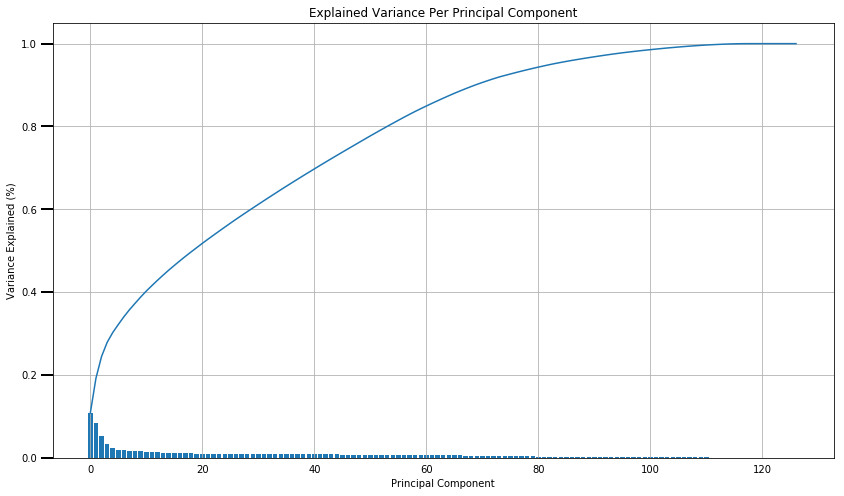

In [35]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_obj)

In [148]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_obj = PCA(40)
azdias_clean_no_nan_scaled_pca = pca_obj.fit_transform(azdias_clean_no_nan_scaled)
azdias_clean_no_nan_scaled_pca.shape

(747109, 40)

### Discussion 2.2: Perform Dimensionality Reduction
From the scree plot, we see that 70% of the variance is explained using 40 features which is reasonable to move ahead. We could go higher but the worry is it could lead to overfitting on training data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Using the data dictionary document can help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- Let's investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, let's write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [37]:
def weight_plot_map(inp_pca, n_comp):
    hahaha=pd.DataFrame(data = inp_pca.components_, columns = azdias_no_outlier_low_miss_encoded.columns.values).iloc[n_comp-1].sort_values(ascending=False)
    hahaha.plot(kind='bar', figsize=(30,4), fontsize=12)
    print(hahaha)

LP_STATUS_GROB_1.0                0.198658
HH_EINKOMMEN_SCORE                0.187102
PLZ8_ANTG3                        0.186971
CAMEO_INTL_2015_WEALTH            0.184444
PLZ8_ANTG4                        0.181426
ORTSGR_KLS9                       0.158900
EWDICHTE                          0.157273
FINANZ_SPARER                     0.147076
FINANZ_HAUSBAUER                  0.141685
FINANZTYP_1                       0.131579
KBA05_ANTG4                       0.130184
PLZ8_ANTG2                        0.127267
KBA05_ANTG3                       0.118237
ANZ_HAUSHALTE_AKTIV               0.116600
ARBEIT                            0.116061
CAMEO_DEUG_2015_9                 0.114685
SEMIO_PFLICHT                     0.112669
RELAT_AB                          0.109172
PRAEGENDE_JUGENDJAHRE_DECADE      0.108794
SEMIO_REL                         0.107840
SEMIO_RAT                         0.095493
SEMIO_TRADV                       0.091896
ZABEOTYP_5                        0.091880
CAMEO_DEUG_

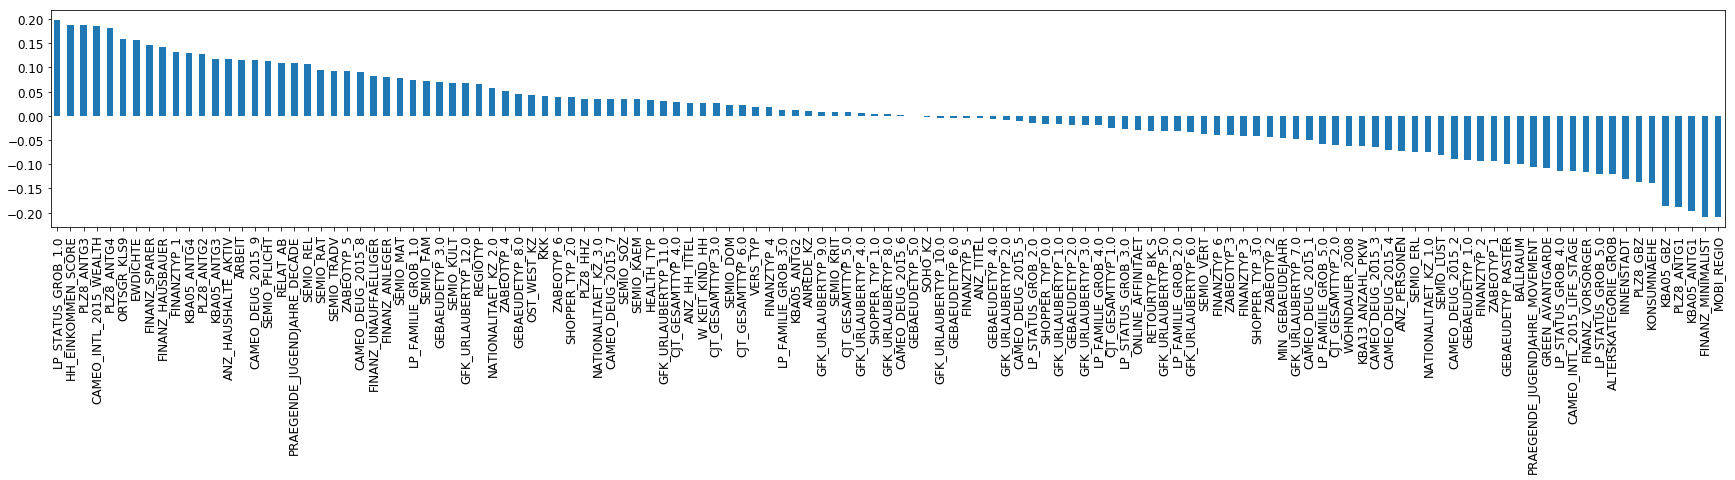

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
weight_plot_map(pca_obj, 1)


ALTERSKATEGORIE_GROB            0.223224
FINANZ_VORSORGER                0.207461
ZABEOTYP_3                      0.203349
SEMIO_ERL                       0.185919
SEMIO_LUST                      0.157013
RETOURTYP_BK_S                  0.155371
W_KEIT_KIND_HH                  0.125182
FINANZ_HAUSBAUER                0.116510
CJT_GESAMTTYP_2.0               0.102830
PLZ8_ANTG3                      0.098593
PLZ8_ANTG4                      0.094376
FINANZTYP_5                     0.094104
EWDICHTE                        0.090488
ORTSGR_KLS9                     0.089819
SEMIO_KRIT                      0.089229
CAMEO_INTL_2015_WEALTH          0.087250
FINANZTYP_2                     0.079125
SEMIO_KAEM                      0.078558
SHOPPER_TYP_3.0                 0.077621
KBA05_ANTG4                     0.073991
ARBEIT                          0.069146
CJT_GESAMTTYP_1.0               0.068130
PLZ8_ANTG2                      0.067319
HH_EINKOMMEN_SCORE              0.067085
ANZ_HAUSHALTE_AK

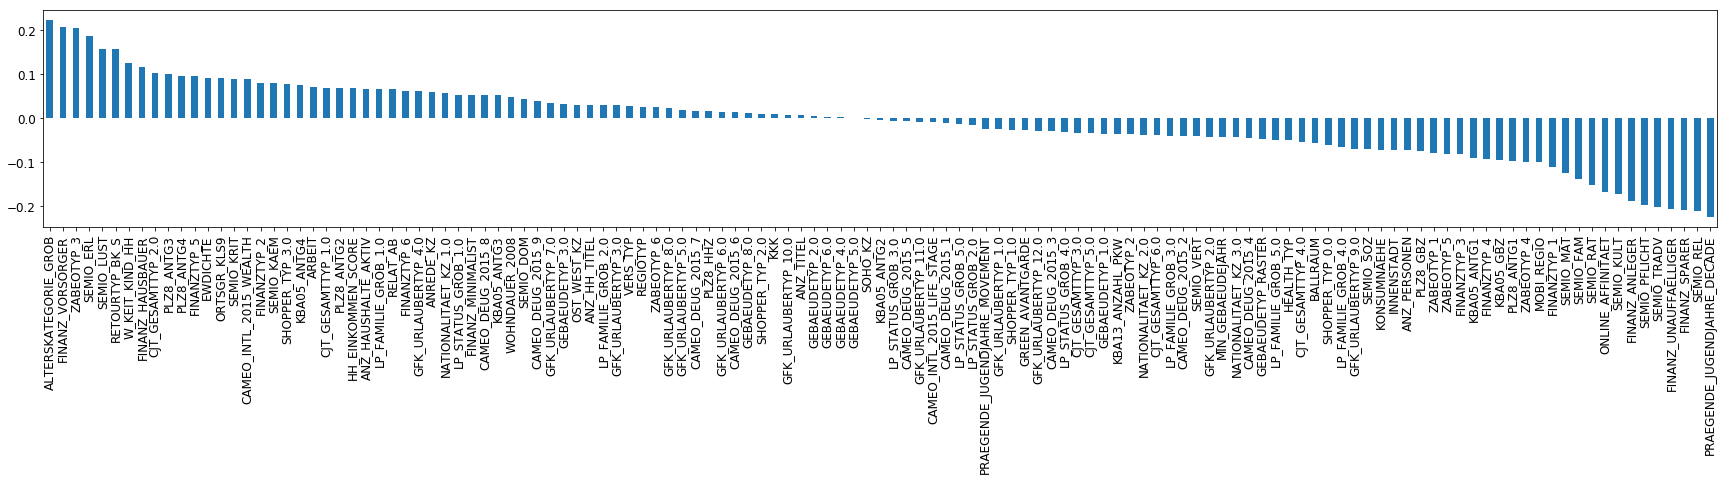

In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_plot_map(pca_obj, 2)


SEMIO_VERT                        0.327483
SEMIO_SOZ                         0.258983
SEMIO_FAM                         0.258336
SEMIO_KULT                        0.243967
FINANZTYP_5                       0.140133
FINANZ_MINIMALIST                 0.132838
SHOPPER_TYP_0.0                   0.127000
ZABEOTYP_1                        0.108309
SEMIO_REL                         0.104724
RETOURTYP_BK_S                    0.090257
W_KEIT_KIND_HH                    0.080821
SEMIO_MAT                         0.076921
FINANZ_VORSORGER                  0.065030
GREEN_AVANTGARDE                  0.055584
EWDICHTE                          0.054876
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.054823
ORTSGR_KLS9                       0.054603
ZABEOTYP_6                        0.051469
PLZ8_ANTG4                        0.049219
PLZ8_ANTG3                        0.048843
SHOPPER_TYP_1.0                   0.045319
SEMIO_LUST                        0.037813
LP_STATUS_GROB_5.0                0.036983
ALTERSKATEG

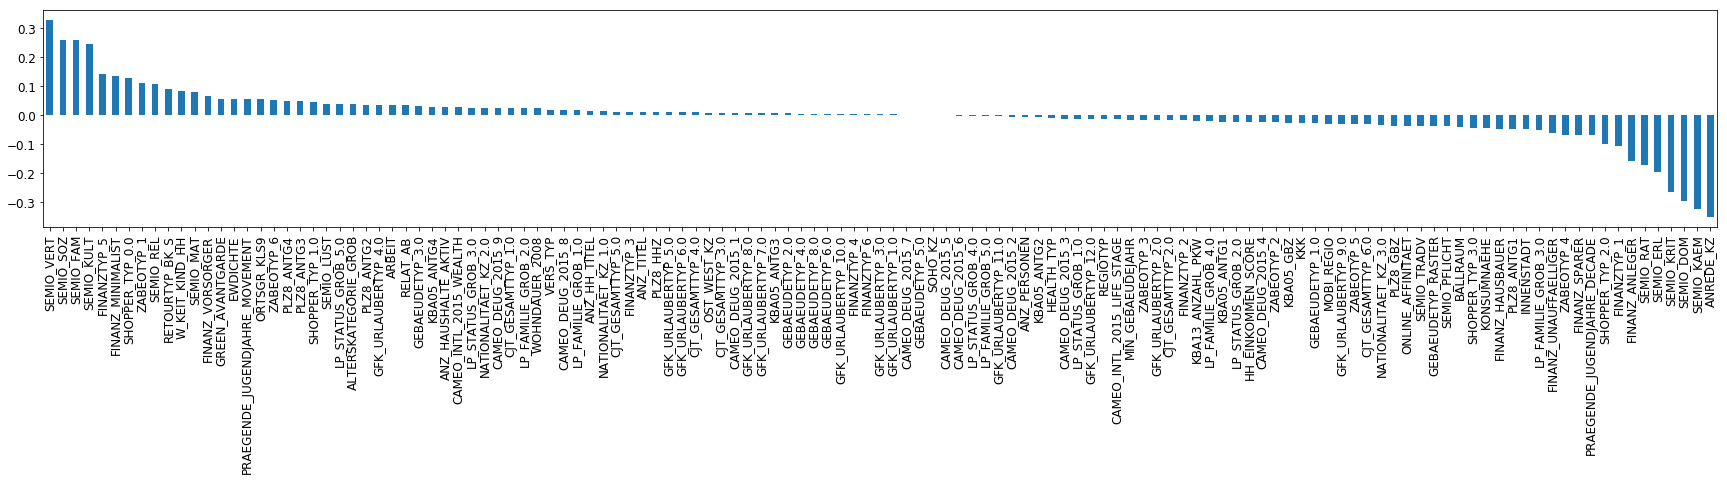

In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_plot_map(pca_obj, 3)


### Discussion 2.3: Interpret Principal Components

1. Component1 (**Financial status**): Positive heavy weights LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_WEALTH are all related to financial status with higher number indicating poorer and lower number indicating richer which is why they are positively correlated. It's also proven by the fact that PLZ8_ANTG3, PLZ8_ANTG4 positively correlate with the previous features but negatively correlate with negative heavy weight PLZ8_ANTG1(1-2 person family homes indicating richer neighborhood).


2. Component2 (**Age**): Looking at the heavy positive & negative weights, we can see that (PRAEGENDE_JUGENDJAHRE_DECADE), (SEMIO_ERL), -ve (RETOURTYP_BK_S), -ve (FINANZ_SPARER) all behave the same way, in other words **youth is more associated with being event oriented, crazy shoppers, financially not savvy** and the opposite for older population.


3. Component3 (**Personality**): Most of the heavy weights in this component deal with personality type. Positive heavy weights (SEMIO_SOZ, SEMIO_FAM, SEMIO_VERT, SEMIO_KULT) show that people who are more socially minded also are more family minded, dreamful and culturally minded. On the other hand, people who have less of above mentioned personalities tend to be more SEMIO_RAT (rational), SEMIO_KAEM (combative), SEMIO_ERL(event oriented, SEMIO_KRIT (critical), SEMIO_DOM (dominant) as indicated by heavy negative weights.
                       

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We'll use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method can be useful here.
- We'll perform the above two steps for a number of different cluster counts. That'll show us how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We'll use this fact to select a final number of clusters in which to group the data.
- Once we've selected a final number of clusters to use, we'll re-fit a KMeans instance to perform the clustering operation. The cluster assignments for the general demographics data should also be obtained, since we'll be using them in the final Step 3.3.

In [41]:
# function that generates internal score given input data and number of clusters
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

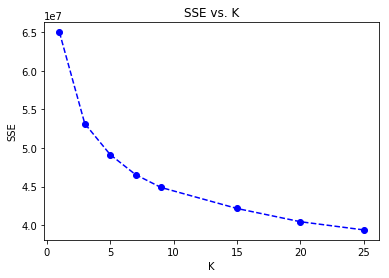

In [42]:
#generate scores for a bunch of clusters and plot them to identify ideal clsuters using elbow method
scores = []
centers = list(range(1,11,2)) + [15, 20, 25]

for center in centers:
    scores.append(get_kmeans_score(azdias_clean_no_nan_scaled_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_gen_pop = KMeans(n_clusters=15)
model_gen_pop = kmeans_gen_pop.fit(azdias_clean_no_nan_scaled_pca)
predict_gen_pop = model_gen_pop.predict(azdias_clean_no_nan_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

Looking at the score vs cluster number plot, we can see that the internal distance dropoff rate reduces significantly from 9 clusters which means that we will not gain too much benefit by adding more clusters. But to be conservative, let's go with the next data point, 15 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- We'll apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (we can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- We'll use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! We'll carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

# Replace any missed columns in customer data with mean values from general data to get same shape
missing_columns_customer_data = azdias_no_outlier_low_miss_encoded.columns.difference(customers_clean.columns)
for each_missed_column in missing_columns_customer_data:
    customers_clean[each_missed_column] = azdias_no_outlier_low_miss_encoded[each_missed_column].mean()

#remove nan
customers_clean_no_nan = imp_median.transform(customers_clean)
#apply feature scaling
customers_clean_no_nan_scaled = scaler_obj.transform(customers_clean_no_nan)
#apply pca feature transformation
customers_clean_no_nan_scaled_pca = pca_obj.transform(customers_clean_no_nan_scaled)
#predict using kmeans model for general population
predict_customers = model_gen_pop.predict(customers_clean_no_nan_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We'll investigate the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here.
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster.
- Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [100]:
uniq_gen, cnts_gen = np.unique(predict_gen_pop, return_counts = True)
print("Cluster number and corresponding % of general population")
pprint.pprint(dict(zip(uniq_gen+1, cnts_gen*100/predict_gen_pop.shape[0])))

Cluster number and corresponding % of general population
{1: 5.7177734440356094,
 2: 6.6105481261770374,
 3: 7.5169754346420667,
 4: 7.3127214368987659,
 5: 7.6559109848763702,
 6: 4.9998059185473602,
 7: 7.8293796487527256,
 8: 6.4178051663144196,
 9: 4.5041620432895337,
 10: 7.1634794922829199,
 11: 5.6555335299133054,
 12: 8.0771346617427984,
 13: 7.1921232377069479,
 14: 8.9650907698876612,
 15: 4.3815561049324794}


In [101]:
uniq_cust, cnts_cust = np.unique(predict_customers, return_counts = True)
print("Cluster number and corresponding % of customer population")
pprint.pprint(dict(zip(uniq_cust+1, cnts_cust*100/predict_customers.shape[0])))

Cluster number and corresponding % of customer population
{1: 1.5259280355550227,
 2: 0.80268611300561354,
 3: 2.1937089194840627,
 4: 3.4895485921140397,
 5: 0.58458932599848601,
 6: 16.669789472895292,
 7: 0.30353676542229086,
 8: 43.477706910895094,
 9: 3.4633170197935952,
 10: 5.4381796787756604,
 11: 6.4117457486116001,
 12: 8.9157366949717822,
 13: 1.9486310866616201,
 14: 0.6497935200521634,
 15: 4.125102115763676}


In [134]:
print("Cluster number and corresponding % (rounded to nearest integer) of general and customer population")
print(" No. Gen  Cust")
pprint.pprint(list(zip(uniq_gen+1, np.round_(cnts_gen*100/predict_gen_pop.shape[0]), np.round_(cnts_cust*100/predict_customers.shape[0]))))

Cluster number and corresponding % (rounded to nearest integer) of general and customer population
 No. Gen  Cust
[(1, 6.0, 2.0),
 (2, 7.0, 1.0),
 (3, 8.0, 2.0),
 (4, 7.0, 3.0),
 (5, 8.0, 1.0),
 (6, 5.0, 17.0),
 (7, 8.0, 0.0),
 (8, 6.0, 43.0),
 (9, 5.0, 3.0),
 (10, 7.0, 5.0),
 (11, 6.0, 6.0),
 (12, 8.0, 9.0),
 (13, 7.0, 2.0),
 (14, 9.0, 1.0),
 (15, 4.0, 4.0)]


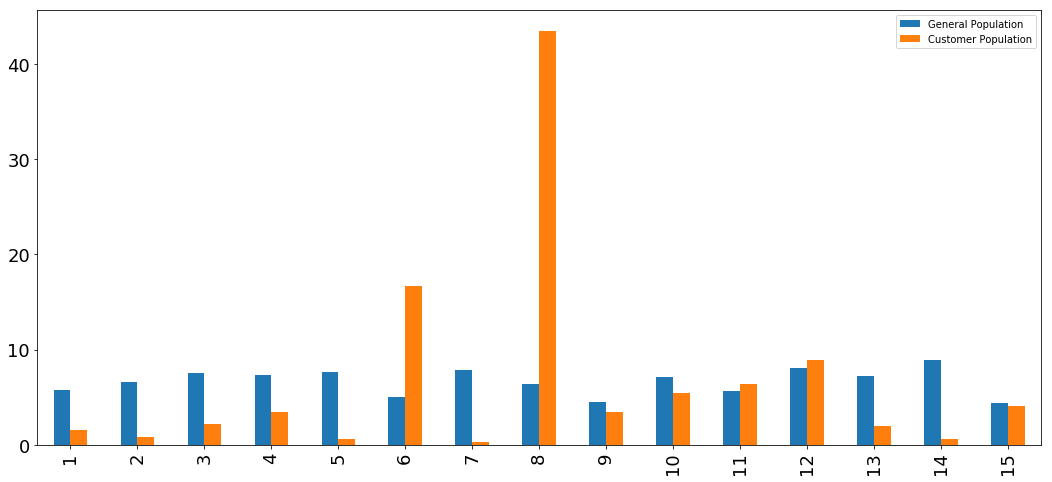

In [135]:
#Vizualization of population distribution among clusters
clust_pop_df = pd.DataFrame(data=cnts_gen*100/predict_gen_pop.shape[0], index = uniq_gen+1, columns = ['General Population'])
clust_pop_df['Customer Population'] = (cnts_cust*100/predict_customers.shape[0])
clust_pop_df.plot(kind='bar', figsize=(18,8), fontsize=18)

In [160]:
# Customer data (cluster = 8) first three component weights
customers_clean_no_nan_scaled_pca[predict_customers == 7][:10,:3]

array([[-5.5559385 ,  1.71129628,  3.91227648],
       [-2.86680561,  0.82529289,  3.39053489],
       [-6.45420981,  0.22764015,  3.31993818],
       [-4.0849696 ,  2.56592929,  4.46238846],
       [-2.96964025, -1.16131321,  2.99560946],
       [-4.76953348, -0.70964233,  4.51430189],
       [-3.96076774, -0.81258555,  4.00315742],
       [-4.98886785, -0.27046798,  4.50059959],
       [-3.07911507, -1.92364485,  2.57633383],
       [-3.43086468,  0.09738046,  2.52973025]])

In [161]:
# Customer data (cluster = 6) first three component weights
customers_clean_no_nan_scaled_pca[predict_customers == 5][:10,:3]


array([[-2.73337703,  5.14202722, -0.53458701],
       [-2.30484268,  3.58436604, -2.79075744],
       [-5.36764661, -0.40543303, -1.25123579],
       [-5.00805818,  3.19187472, -0.95759989],
       [-5.33754881,  1.69610241, -1.45636841],
       [-2.78123209,  3.42522853, -1.39878722],
       [-4.08622344,  3.28095885, -1.02299348],
       [-7.48460296,  1.93392076, -1.68558824],
       [-3.95451636,  1.98820704, -0.6122819 ],
       [-1.3100991 ,  0.92757761, -1.97389928]])

In [162]:
# Customer data (cluster = 14) first three component weights
customers_clean_no_nan_scaled_pca[predict_customers == 13][:10,:3]

array([[ 3.09603998,  0.16968539, -2.21603522],
       [ 4.56989729, -0.68361603, -1.89173919],
       [ 2.14603432, -3.09656139, -2.14275065],
       [ 4.01205548, -0.57163224, -2.93877433],
       [ 4.44145849, -1.20731902, -1.98278519],
       [ 4.66936331, -0.41544771, -2.45752317],
       [ 5.97740583,  0.18279205, -1.98477241],
       [ 6.43588625,  0.15796133, -0.78138688],
       [ 5.01745712, -0.01414867, -0.96876163],
       [ 7.49787611, -0.28551831, -0.72035149]])

In [164]:
# Customer data (cluster = 5) first three component weights
customers_clean_no_nan_scaled_pca[predict_customers == 4][:10,:3]

array([[ 3.78891492,  0.9059919 ,  3.50183619],
       [ 3.78891492,  0.9059919 ,  3.50183619],
       [ 3.63359684, -2.87569612,  5.22501002],
       [ 4.24124898, -2.1618828 ,  5.9649958 ],
       [ 2.8582216 ,  0.09170956,  2.00890925],
       [ 1.35774592, -0.48423351,  2.34001355],
       [ 3.56179566, -3.88076686,  2.8219228 ],
       [ 5.23165566, -2.63235978,  4.13607766],
       [ 5.40313888, -1.60500693,  2.98491379],
       [ 1.6523707 , -2.56666657,  3.72254305]])

### Discussion 3.3: Compare Customer Data to Demographics Data

The above bar chart distribution of general & customer population shows that clusters 8 & 6 are over-represented in Customer data and clusters 14 & 5 are over-represented in General population data. 
  1. If we look at the first 3 principal component weights for clusters 8 & 6, we can see that they have heavy negative correlation with first component (aka FINANCIAL STATUS). The next two components don't seem to follow a pattern though cluster 8 has strong positive correlation with third component (aka PERSONALITY), and cluster 6 has positive correlation with second component (aka AGE).


  2. Similarly, if we look at the first 3 principal component weights for clusters 14 & 5, we can see that the opposite is true. The first component (aka FINANCIAL STATUS) has a positive correlation with those clusters. The other two components do not seem to follow a pattern.
  
Conclusion: Based on the interpretation of principal components and what we see from the cluster data, FINANCIAL STATUS has a positive correlation with potential customer base. In other words, richer population has higher chance of signing up for mail order compared to poorer population. To further study the effects of AGE and PERSONALITY, these over-represented and under-represented clusters need to be separated out from main dataset and further clustering needs to be done on them.
  